<a href="https://colab.research.google.com/github/bala-baskar/aiml_tech_courses/blob/main/pytorch/05_pytorch_going_modular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05. PyTorch Going Modular Exercises

In [2]:
import os
PATH = './going_modular'
if not os.path.isdir(PATH):
  os.makedirs(PATH)
  os.chdir(PATH)
print(os.getcwd())

/content/going_modular


In [18]:
%%writefile get_data.py
import argparse
import os
import requests
import zipfile
from pathlib import Path

def get_args():
  parser = argparse.ArgumentParser("Get the path directory to download!")
  parser.add_argument("-p","--path",help='get the directory path to save the downloaded data')
  args = parser.parse_args()
  return args.path

def data_download(PATH):
  # Setup path to data folder
  image_path = PATH + "/pizza_steak_sushi"

  # If the image folder doesn't exist, download it and prepare it...
  if os.path.isdir(image_path):
      print(f"{image_path} directory exists.")
  else:
      print(f"Did not find {image_path} directory, creating one...")
      os.makedirs(image_path)

  # Download pizza, steak, sushi data
  with open(PATH + "/pizza_steak_sushi.zip", "wb") as f:
      request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
      print("Downloading pizza, steak, sushi data...")
      f.write(request.content)

  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(PATH + "/pizza_steak_sushi.zip", "r") as zip_ref:
      print("Unzipping pizza, steak, sushi data...")
      zip_ref.extractall(image_path)

  # Remove zip file
  os.remove(PATH + "/pizza_steak_sushi.zip")

if __name__ == '__main__':
  PATH = get_args()
  print(PATH)
  data_download(PATH)

Overwriting get_data.py


In [19]:
!python get_data.py -p './data'

./data
Did not find ./data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [20]:
%%writefile data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

Writing data_setup.py


In [21]:
%%writefile model_builder.py
"""
Contains PyTorch model code to instantiate a TinyVGG model.
"""
import torch
from torch import nn

class TinyVGG(nn.Module):
  """Creates the TinyVGG architecture.

  Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
  See the original architecture here: https://poloclub.github.io/cnn-explainer/

  Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
      )

  def forward(self, x: torch.Tensor):
      x = self.conv_block_1(x)
      x = self.conv_block_2(x)
      x = self.classifier(x)
      return x
      # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

Writing model_builder.py


In [23]:
%%writefile engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

Writing engine.py


In [24]:
%%writefile utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Writing utils.py


In [31]:
%%writefile train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import os
import torch
import data_setup, engine, model_builder, utils
import argparse
from torchvision import transforms

def get_args():
  parser = argparse.ArgumentParser("Get all the parameters from user")
  parser.add_argument('-e','--epochs',help='number of epochs')
  parser.add_argument('-b','--batch_size',help='batch size')
  parser.add_argument('-hu','--hidden_units',help='number of hidden units')
  parser.add_argument('-lr','--alpha',help='learning rate')
  parser.add_argument('-m','--model_path',help='model_path')
  args = parser.parse_args()
  return args


def main(args):

  # Setup hyperparameters
  NUM_EPOCHS = int(args.epochs)
  BATCH_SIZE = int(args.batch_size)
  HIDDEN_UNITS = int(args.hidden_units)
  LEARNING_RATE = float(args.alpha)
  MODEL_PATH = args.model_path

  # Setup directories
  train_dir = "data/pizza_steak_sushi/train"
  test_dir = "data/pizza_steak_sushi/test"

  # Setup target device
  device = "cuda" if torch.cuda.is_available() else "cpu"

  # Create transforms
  data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
  ])

  # Create DataLoaders with help from data_setup.py
  train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
      train_dir=train_dir,
      test_dir=test_dir,
      transform=data_transform,
      batch_size=BATCH_SIZE
  )
  print("DataLoader created")
  # Create model with help from model_builder.py
  model = model_builder.TinyVGG(
      input_shape=3,
      hidden_units=HIDDEN_UNITS,
      output_shape=len(class_names)
  ).to(device)
  print("Initiated model object")
  # Set loss and optimizer
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),
                              lr=LEARNING_RATE)
  print("Loss function and optimizer are initiated")
  # Start training with help from engine.py
  engine.train(model=model,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              epochs=NUM_EPOCHS,
              device=device)

  # Save the model with help from utils.py
  utils.save_model(model=model,
                  target_dir="models",
                  model_name=MODEL_PATH)

if __name__ == '__main__':
  args = get_args()
  main(args)

Overwriting train.py


In [66]:
%%writefile predict.py
import argparse
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import model_builder

def get_args():
  parser = argparse.ArgumentParser()
  parser.add_argument('-m','--model_path',help='path of model to be used for prediction')
  parser.add_argument('-i','--image_path',help='path of input image to be used for prediction')
  args = parser.parse_args()
  return args

def main(args):

  MODEL_PATH = args.model_path
  IMAGE_PATH = args.image_path

  # Setup target device
  device = "cuda" if torch.cuda.is_available() else "cpu"
  class_names = ['pizza','sushi','steak']

  img = Image.open(IMAGE_PATH)
  #Tranform the image
  img_transformer = transforms.Compose([transforms.Resize((64,64)),
                                          transforms.ToTensor()])
  transformed_img = img_transformer(img)

  #Load the model
  model = model_builder.TinyVGG(
      input_shape=3,
      hidden_units=10,
      output_shape=3
  ).to(device)
  trained_params = torch.load(MODEL_PATH,weights_only=True)
  model.load_state_dict(trained_params)

  #Prediction
  y_pred = model(transformed_img.unsqueeze(dim=0))
  y_pred_prob = torch.softmax(y_pred,dim=1)
  y_pred_class = torch.softmax(y_pred,dim=1).argmax(dim=1).item()
  y_pred_label = class_names[y_pred_class]
  print(f"Prediction class: {y_pred_label}| prob {round(y_pred_prob.squeeze().detach().numpy()[y_pred_class]*100.0,2)} %")

if __name__ == '__main__':
  args = get_args()
  main(args)

Overwriting predict.py


In [54]:
!python train.py --epochs 20 --batch_size 32 --hidden_units 10 --alpha 0.001 --model_path 'tinyvgg_foodvision_v1.pth'

DataLoader created
Initiated model object
Loss function and optimizer are initiated
  0% 0/20 [00:00<?, ?it/s]Epoch: 1 | train_loss: 1.0944 | train_acc: 0.3711 | test_loss: 1.1049 | test_acc: 0.2604
  5% 1/20 [00:01<00:33,  1.75s/it]Epoch: 2 | train_loss: 1.1067 | train_acc: 0.3086 | test_loss: 1.1138 | test_acc: 0.2708
 10% 2/20 [00:03<00:31,  1.76s/it]Epoch: 3 | train_loss: 1.0633 | train_acc: 0.4297 | test_loss: 1.0577 | test_acc: 0.4527
 15% 3/20 [00:05<00:29,  1.75s/it]Epoch: 4 | train_loss: 1.0121 | train_acc: 0.5820 | test_loss: 0.9674 | test_acc: 0.5938
 20% 4/20 [00:06<00:27,  1.74s/it]Epoch: 5 | train_loss: 0.9734 | train_acc: 0.3945 | test_loss: 1.0527 | test_acc: 0.3712
 25% 5/20 [00:08<00:26,  1.74s/it]Epoch: 6 | train_loss: 0.8445 | train_acc: 0.6445 | test_loss: 1.0704 | test_acc: 0.3314
 30% 6/20 [00:11<00:29,  2.08s/it]Epoch: 7 | train_loss: 0.8853 | train_acc: 0.4883 | test_loss: 1.1377 | test_acc: 0.2604
 35% 7/20 [00:13<00:26,  2.03s/it]Epoch: 8 | train_loss: 0.7471

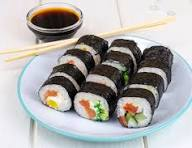

In [70]:
from PIL import Image
Image.open('/content/sushi.jpg')

In [69]:
!python predict.py -m './models/tinyvgg_foodvision_v1.pth' -i '/content/sushi.jpg'

Prediction class: sushi| prob 48.94 %
